In [108]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


%matplotlib inline

plt.rc('axes', labelsize=20) 
plt.rcParams["figure.figsize"] = (10,10)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13) 
mpl.rcParams['axes.titlesize'] = 24

In [109]:
resultados_eleicoes_df = pd.read_excel('data/raw_data/ResultadosEleicoesAutarquicas2005.xls')

In [110]:
# I only want the results referring to the "Câmara municipal" elections of Concelhos. 
resultados_cm_df = resultados_eleicoes_df[(resultados_eleicoes_df.Orgao == 'CM') & (resultados_eleicoes_df.Freguesia.isnull())]
resultados_cm_df = resultados_cm_df.drop('Orgao', 1)

# Because of the last filtering the Freguesia column will always be null, so I can drop it. 
resultados_cm_df = resultados_cm_df.drop('Freguesia', 1)

# Drop unnused column
resultados_cm_df.drop('Validos', 1, inplace=True)
resultados_cm_df.drop('Distrito', 1, inplace=True)

# I don't want the results by District
resultados_cm_df = resultados_cm_df[resultados_cm_df.Concelho.notnull()]

# I don't know what DICOFR stands for but it seems redudant with Ref_Municipio_INE
resultados_cm_df = resultados_cm_df.drop('Dicofr', 1)

# Normalize the values of this column with the values of the 2013 data
resultados_cm_df['Ref_municipio_ine'] = resultados_cm_df['Ref_municipio_ine'].apply(lambda x: str(x)[:-2])

# Make column names more understandable 
resultados_cm_df = resultados_cm_df.rename(columns={
                        'Ref_municipio_ine': 'INE_ID',
                        'M': 'Mandatos'
                    })

# Create %Abstention Column
resultados_cm_df['Abstention (%)'] = 100 - ((resultados_cm_df.Votantes / resultados_cm_df.Inscritos) * 100)

# Add Year Column
resultados_cm_df['year'] = 2005

In [111]:
assert len(resultados_cm_df[resultados_cm_df.Inscritos.isnull()]) == 0

In [112]:
def change_calhetas_ine_ids(row):
    row_index = row.name
    if row.Concelho == 'CALHETA (R.A.M.)':
        resultados_cm_df.set_value(col='INE_ID', index=row_index, value=3101)
    if row.Concelho == 'CALHETA (R.A.A.)':
        resultados_cm_df.set_value(col='INE_ID', index=row_index, value=4501)
    

# INE_IDs of Calhetas of Madeira and Açores are changed. Correct that.
resultados_cm_df.apply(lambda row: change_calhetas_ine_ids(row), 1)
print 'ok'

ok


In [113]:
resultados_cm_df = resultados_cm_df.set_index('INE_ID')
resultados_cm_df.to_csv('data/processed_data/local_elections_2005_results.csv', encoding='utf-8')

# Analyse Abstention

### Check relationship between number of people enrolled to vote and abstention

In [21]:
enrolled_abstention = resultados_cm_df.ix[:, ['Inscritos', 'Abstention (%)']].drop_duplicates()
enrolled_abstention = enrolled_abstention[enrolled_abstention.Inscritos.notnull()]

Correlation Cofficient: 0.403233960211
p-value: 1.79934889575e-13


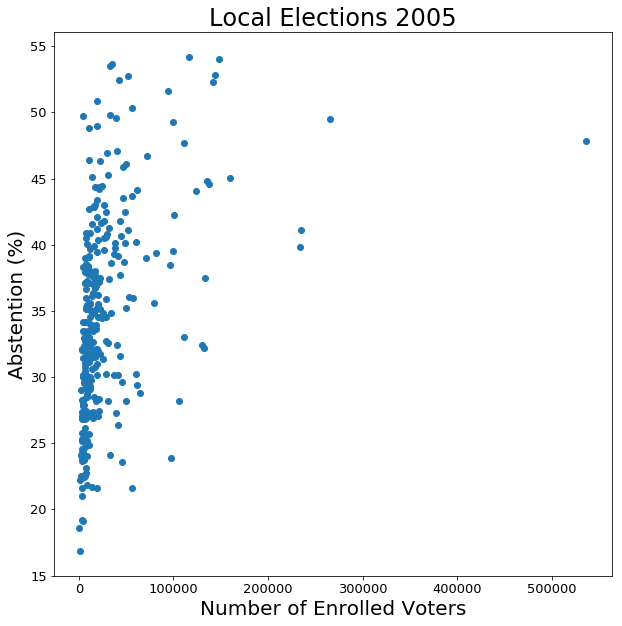

In [24]:
# Correlation using all the data
plot = plt.scatter(enrolled_abstention.Inscritos, enrolled_abstention['Abstention (%)'])
plt.xlabel('Number of Enrolled Voters')
plt.ylabel('Abstention (%)')
plt.title('Local Elections 2005')

# Pearson Correlation Coefficient and p-value
corr_cof, p_value = pearsonr(enrolled_abstention.Inscritos, enrolled_abstention['Abstention (%)'])
print 'Correlation Cofficient: {}'.format(corr_cof)
print 'p-value: {}'.format(p_value)

Correlation Cofficient: 0.588369328989
p-value: 4.48447172108e-30


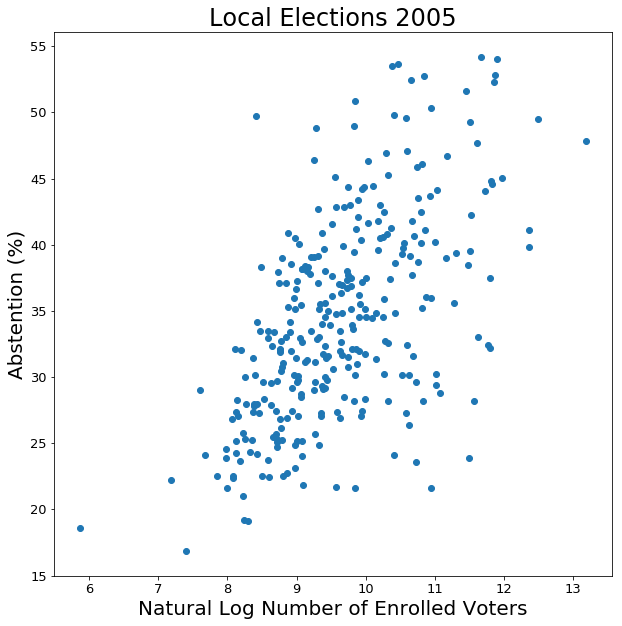

In [26]:
# What if I used the log of the Number of Enrolled Voters?
plot = plt.scatter(np.log(enrolled_abstention.Inscritos), enrolled_abstention['Abstention (%)'])
plt.xlabel('Natural Log Number of Enrolled Voters')
plt.ylabel('Abstention (%)')
plt.title('Local Elections 2005')

# Pearson Correlation Coefficient and p-value
corr_cof, p_value = pearsonr(np.log(enrolled_abstention.Inscritos), enrolled_abstention['Abstention (%)'])
print 'Correlation Cofficient: {}'.format(corr_cof)
print 'p-value: {}'.format(p_value)